In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers
from _collections import deque, defaultdict

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# BlackJack

In [2]:
env = gym.make('Blackjack-v0')

PLAYER_STATE = 0
DEALER_STATE = 1
USABLE_ACE = 2

PLAYER_STATE_COUNT = env.observation_space.spaces[PLAYER_STATE].n
DEALER_STATE_COUNT = env.observation_space.spaces[DEALER_STATE].n
USABLE_ACE_COUNT = env.observation_space.spaces[USABLE_ACE].n

ACTION_SPACE = 2 #env.action_space.n

ENVIRONMENT_SPACE = PLAYER_STATE_COUNT * DEALER_STATE_COUNT * USABLE_ACE_COUNT


def get_state_index(state):
    index = state[PLAYER_STATE] * (DEALER_STATE_COUNT * USABLE_ACE_COUNT)
    
    index += state[DEALER_STATE] * USABLE_ACE_COUNT
    
    if (state[USABLE_ACE] == True):
        index += 1
        
    return index

def get_discounted_reward (rewards, gamma):
    discounted_reward = 0
    gamma_value = gamma
    for rewardIx in range(len(rewards)):
        discounted_reward += rewards[rewardIx] * gamma_value
        gamma_value *= gamma
    return discounted_reward

def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

correct_policy = np.ones([PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT]).astype(int)
correct_policy[12, 4:7, 0] = 0
correct_policy[13, 2:7, 0] = 0
correct_policy[14, 2:7, 0] = 0
correct_policy[15, 2:7, 0] = 0
correct_policy[16, 2:7, 0] = 0
correct_policy[17:22, :, 0] = 0
correct_policy[18, 2:9, 1] = 0
correct_policy[19:22, :, 1] = 0
correct_policy = correct_policy.flatten()


less_than_20_policy = np.ones([PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT]).astype(int)
less_than_20_policy[20:22, :, :] = 0
less_than_20_policy = less_than_20_policy.flatten()

## Value of Policy Using Monte Carlo

In [3]:
NUMBER_OF_EPISODES = 100000
gamma = 1
policy = correct_policy

mc_state_values = np.zeros(ENVIRONMENT_SPACE)
mc_state_visits = np.zeros(ENVIRONMENT_SPACE)

for episodeIx in range(NUMBER_OF_EPISODES):
    episode = []
    rewards = []
    state = env.reset()
    done = False
        
    # Run a episode
    episode.append(state)
    rewards.append(0)
    
    while not done:
        action = policy[get_state_index(state)]
        state, reward, done, _ = env.step(action)
        episode.append(state)
        rewards.append(reward)
     
    # Update values
    for stepIx, state in enumerate(episode):
        state_index = get_state_index(state)
        state_value = get_discounted_reward(rewards[stepIx:], gamma)
        mc_state_visits[state_index] += 1
        alpha = 1.0 / mc_state_visits[state_index]
        mc_state_values[state_index] += alpha * (state_value - mc_state_values[state_index])

mc_state_values = mc_state_values.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)

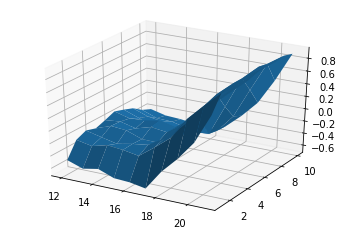

In [4]:
x = range(12, 22)
y = range(1, 11)

data = mc_state_values[12:22,1:11,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X.T, Y.T, data)

plt.show()

## Value of Policy using TD(0)

In [5]:
NUMBER_OF_EPISODES = 100000
gamma = 1
policy = correct_policy

td0_state_values = np.zeros(ENVIRONMENT_SPACE)
td0_state_visits = np.zeros(ENVIRONMENT_SPACE)

episodeIx = 0
state = env.reset() # start the environment and get initial state

while episodeIx < NUMBER_OF_EPISODES:
    # Act according to policy
    action = policy[get_state_index(state)]
    new_state, reward, done, _ = env.step(action)
    
    # Update current estimate for last state
    state_index = get_state_index(state)
    new_state_index = get_state_index(new_state)
    td_error = reward + gamma * td0_state_values[new_state_index] - td0_state_values[state_index]
    
    td0_state_visits[state_index] += 1
    alpha = 1.0 / td0_state_visits[state_index]
    
    td0_state_values[state_index] += (alpha * td_error)
    
    # If we reached the end of an episode, reset the environment and continue
    if done:
        episodeIx += 1
        td0_state_values[new_state_index] += (alpha * - td0_state_values[new_state_index])
        state = env.reset()
    else:
        state = new_state

td0_state_values = td0_state_values.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)

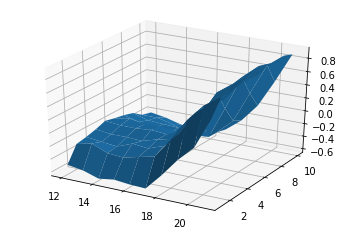

In [6]:
x = range(12, 22)
y = range(1, 11)

data = td0_state_values[12:22,1:11,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X.T, Y.T, data)

plt.show()

# Value of Policy using TD(Lambda)

In [7]:
NUMBER_OF_EPISODES = 100000
gamma = 1
policy = correct_policy

tdl_state_values = np.zeros(ENVIRONMENT_SPACE)
tdl_state_visits = np.zeros(ENVIRONMENT_SPACE)
eligibility = np.zeros(ENVIRONMENT_SPACE)

lambdah = 0.9
episodeIx = 0
state = env.reset() # start the environment and get initial state

while episodeIx < NUMBER_OF_EPISODES:
    # Act according to policy
    action = policy[get_state_index(state)]
    new_state, reward, done, _ = env.step(action)
    
    # Update current estimate for last state
    state_index = get_state_index(state)
    new_state_index = get_state_index(new_state)

    # Update eligibilities
    eligibility *= lambdah * gamma
    eligibility[state_index] += 1.0
    
    td_error = reward + (gamma * tdl_state_values[new_state_index]) - tdl_state_values[state_index]
    
    tdl_state_visits[state_index] += 1
    alpha = 1.0 / tdl_state_visits[state_index]
    
    tdl_state_values += alpha * td_error * eligibility
    
    # If we reached the end of an episode, reset the environment and continue
    if done:
        episodeIx += 1
        tdl_state_values = tdl_state_values + alpha * (- tdl_state_values[new_state_index] * eligibility)
        eligibility = np.zeros(PLAYER_STATE_COUNT * DEALER_STATE_COUNT * USABLE_ACE_COUNT)
        state = env.reset()
    else:
        state = new_state

tdl_state_values = tdl_state_values.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)

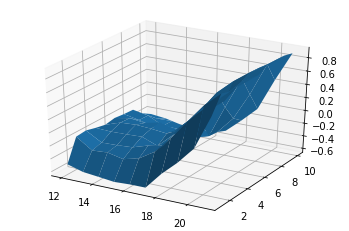

In [8]:
x = range(12, 22)
y = range(1, 11)

data = tdl_state_values[12:22,1:11,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X.T, Y.T, data)

plt.show()

# GLIE - Monte Carlo

In [9]:
Q_mc = np.random.rand(ENVIRONMENT_SPACE, ACTION_SPACE)
N = np.zeros([ENVIRONMENT_SPACE, ACTION_SPACE])
policy = make_epsilon_greedy_policy(Q_mc, 0.1, ACTION_SPACE)

NUMBER_OF_EPISODES = 500000
gamma = 1

for episodeIx in range(NUMBER_OF_EPISODES):
    episode = []
    state = env.reset()
    done = False
        
    # Run a episode
    while not done:
        stateIx = get_state_index(state)
        probs = policy(stateIx)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        new_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = new_state
        
    for stepIx, step in enumerate(episode):
        stepStateIx = get_state_index(step[0])
        stepAction = step[1]
        G = 0
        for i, stepReward in enumerate(episode[stepIx:]):
            G += (gamma**i) * stepReward[2]
            
        N[stepStateIx,stepAction] +=1
        qoffset = 1/N[stepStateIx,stepAction]*(G-Q_mc[stepStateIx,stepAction])
        Q_mc[stepStateIx,stepAction] += qoffset

learned_policy_mc = np.argmax(Q_mc,axis=1)
view_learned_policy_mc = learned_policy_mc.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)
view_correct_policy = correct_policy.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)
error_rate = np.mean((np.bitwise_xor(view_learned_policy_mc[4:22, :, :], view_correct_policy[4:22, :, :])))
print(error_rate)

0.16161616161616163


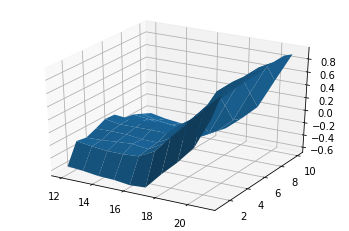

In [10]:
q_max_mc = np.amax(Q_mc, axis=1)
q_max_mc = q_max_mc.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)

x = range(12, 22)
y = range(1, 11)

data = q_max_mc[12:22,1:11,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X.T, Y.T, data)

plt.show()

In [11]:
rewardTotal = 0
policy = correct_policy

for episodeIx in range(10000):
    state = env.reset()
    done = False
    
    # Run a episode
    while not done:
        action = policy[get_state_index(state)]
        state, reward, done, _ = env.step(action)

    rewardTotal += reward
print(rewardTotal)

-648.0


# SARSA

In [16]:
Q_sarsa = np.random.rand(ENVIRONMENT_SPACE, ACTION_SPACE)
k = np.zeros(ENVIRONMENT_SPACE)

NUMBER_OF_EPISODES = 500000
gamma = 1
lambdah = 0.0

episodeIx = 0
while episodeIx < NUMBER_OF_EPISODES:

    eligibility_sarsa = np.zeros((ENVIRONMENT_SPACE, ACTION_SPACE))
    
    done = False
    
    state = env.reset()
    state_index = get_state_index(state)
    action = np.argmax(Q_sarsa[state_index,:] + np.random.randn(1,ACTION_SPACE)*(150./(k[state_index]+1)))
    
    while done == False:
        new_state, reward, done, _ = env.step(action)
        
        new_state_index = get_state_index(new_state)
        new_action = np.argmax(Q_sarsa[new_state_index,:] + np.random.randn(1,ACTION_SPACE)*(150./(k[state_index]+1)))
        
        if done:
            td_error = reward - Q_sarsa[state_index, action]
            episodeIx+=1
        else:
            td_error = reward + (gamma*Q_sarsa[new_state_index, new_action]) - Q_sarsa[state_index, action]   
        
        k[state_index]+=1
        alpha = 1. / k[state_index]
       
        eligibility_sarsa[state_index,action] += 1
        Q_sarsa += alpha * td_error * eligibility_sarsa
        
        eligibility_sarsa *= gamma * lambdah
        state, action = new_state, new_action
        
learned_policy_sarsa = np.argmax(Q_sarsa,axis=1)
view_learned_policy_sarsa = learned_policy_sarsa.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)
view_correct_policy = correct_policy.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)
error_rate = np.mean((np.bitwise_xor(view_learned_policy_sarsa[4:22, :, :], view_correct_policy[4:22, :, :])))
print(error_rate)

0.36363636363636365


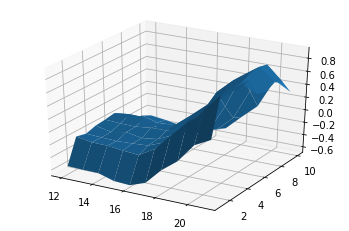

In [17]:
q_max_sarsa = np.amax(Q_sarsa, axis=1)
q_max_sarsa = q_max_sarsa.reshape(PLAYER_STATE_COUNT, DEALER_STATE_COUNT, USABLE_ACE_COUNT)

x = range(12, 22)
y = range(1, 11)

data = q_max_sarsa[12:22,1:11,0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X.T, Y.T, data)

plt.show()

In [18]:
rewardTotal = 0
policy = learned_policy_sarsa

for episodeIx in range(10000):
    state = env.reset()
    done = False
    
    # Run a episode
    while not done:
        action = policy[get_state_index(state)]
        state, reward, done, _ = env.step(action)

    rewardTotal += reward
print(rewardTotal)

-1250.0
